In [1]:
# Basic
import pandas as pd
import numpy as np

# Visualization
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

# Text cleaning
import re
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

[nltk_data] Downloading package punkt to /home/spyros/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/spyros/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# read and display the data
df_initial = pd.read_json('train_reviews.json')
display(df_initial.head(), df_initial.shape)

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium


(2021, 5)

#  First Basic exploration

> In this first part I will explore the dataset, the variable types, shapes, and make sure it is clear for nulls/duplicates in order to avoid later errors

In [4]:
# Check for nulls
def isnull(dataframe):
    return df_initial.isnull().values.any(), missingno.matrix(df_initial, figsize=(8,4))

# Check for duplicates
def isduplicated(dataframe):
    return df_initial.duplicated().any()

nulls: (False, <AxesSubplot:>)


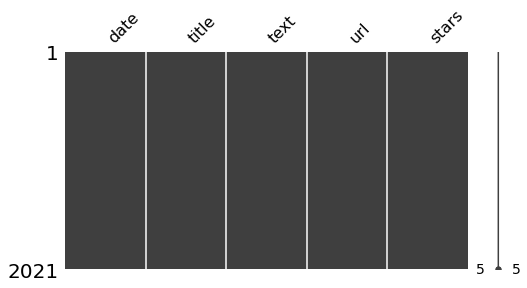

In [5]:
print('nulls:', isnull(df_initial))

In [6]:
print('duplicates:', isduplicated(df_initial))

duplicates: True


Seems weird to have duplicates in reviews. Maybe double-clicks or something but lets investigate further:

In [7]:
print('number of diplicated rows:',  df_initial[df_initial.duplicated(subset='date')].shape[0]) 

number of diplicated rows: 580


In [8]:
print('Example -> line indexed by the number 91 is present', 
      df_initial[df_initial['title'] == df_initial[91:92]['title'].values[0]].shape[0],'times in the initial dataset')

Example -> line indexed by the number 91 is present 21 times in the initial dataset


In [9]:
# Drop the duplicated rows
df_initial.drop_duplicates(subset='date',inplace=True)
df_initial.reset_index(drop=True, inplace=True)
print(df_initial.shape)

(1441, 5)


So after dropping the duplicated rows, we can also take an overall glance again.  

A Datetime object and 4 object typed non-null variables. We are good to go!

In [10]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1441 entries, 0 to 1440
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    1441 non-null   datetime64[ns, UTC]
 1   title   1441 non-null   object             
 2   text    1441 non-null   object             
 3   url     1441 non-null   object             
 4   stars   1441 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 56.4+ KB


In [11]:
# Save a copy of the dataframe, to work with it in the following stages of the analysis
df = df_initial.copy()

In [12]:
df

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
3,2015-01-13 12:26:52+00:00,Very good,Saved about £50 on a single trip using Nationa...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
4,2011-05-28 15:00:36+00:00,Check it out.,I always use the national rail enquiry site wh...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-4 star-rating--medium
...,...,...,...,...,...
1436,2017-07-06 20:20:58+00:00,Late,"Late, cancelled, signal failures, too much rai...",https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-1 star-rating--medium
1437,2016-11-29 10:26:41+00:00,Not sure why they even have timetables,Trains are constantly delayed or cancelled. I ...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-1 star-rating--medium
1438,2016-07-17 07:42:11+00:00,Helpful guards,On a yearly basis we take a group of Preschool...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-5 star-rating--medium
1439,2016-05-22 12:25:51+00:00,Often late but clean and decent.,I travel by them every day. I like their newis...,https://uk.trustpilot.com/review/www.southeast...,star-rating star-rating-3 star-rating--medium


# Column pre-processing

In this part, I will generate new columns and process/transform the existed ones, to a valid form for the following parts of the Analysis

>    <b> 1. Date format </b>

Lets break the Timestamp column and generate some other date and time related columns that will be used later for the exploratory analysis, and insight extraction

In [13]:
df.rename(columns={'date':'Timestamp'}, inplace=True)

# Produce new date-like columns
df['Date'] = df['Timestamp'].dt.strftime('%d/%m/%Y')
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Time'] = df['Timestamp'].dt.strftime("%H:%M:%S")

With this function I will -kind of arbitrary- set the type of the route in terms of time (morning train, afternoon train, night train)

In [14]:
# Helping function to cluster the hours / seasons

def set_the_timezone(time):
    if time > '22:00:00' and time < '05:59:59':
        timezone = 'night train'
    elif time > '06:00:00' and time < '13:59:59':
        timezone = 'morning train'
    else: 
        timezone = 'afternoon train'
    return timezone

def set_the_season(month):
    if month==12 or (month>=1 and month<3):
        season = 'winter'
    elif month>=3 and month<6:
        season = 'spring'
    elif month>=6 and month < 9:
        season = 'summer'
    else: 
        season = 'autumn'
    return season

df['Train_timezone'] = df['Time'].apply(set_the_timezone)
df['Season'] = df['Month'].apply(set_the_season)

In [15]:
# Sort by Timestamp
df.sort_values(by='Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='Timestamp'>

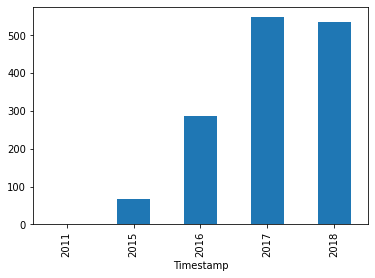

In [16]:
df['title'].groupby(df["Timestamp"].dt.year).count().plot(kind="bar")

Based on that 2011 and 2015 will be excluded from the later analysis due to lack of reviews

>    <b> 2. Ratings </b>

Here I extract as an integer the rating number and a short visualized analysis is also presented 

In [17]:
def starsExtraction(value):
    return int(re.findall(r'\d+', value)[0])
    #return int(value.split('-')[3][0])

df['Rating'] = df['stars'].apply(starsExtraction)

Both this regex command and split function can be dangerous, cause no one assures that the long df['stars'] string only contains one number or keeps the pattern of the dash-splits going, so I will run a 'unique' function-command to be sure of the outcome

In [18]:
df['Rating'].unique()

array([4, 5, 2, 1, 3])

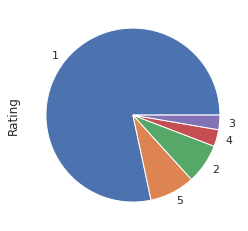

In [19]:
sns.set_theme(style='whitegrid')
df['Rating'].value_counts().plot(kind='pie');

Passengers do not seem very happy at a first glance

>    <b> 3. URL </b>

Urls seemed irrelevant at first sight, but after the following commands its crear that we can extract the company's name from this column. 
There are 76 unique urls but they redirect to different comment pages so the company number should be significantly smaller than that.
Lets find out

In [20]:
display(df['url'].value_counts().head(), 
        'unique urls:', df['url'].nunique())

https://uk.trustpilot.com/review/www.southernrailway.com?page=3    20
https://uk.trustpilot.com/review/www.southernrailway.com?page=5    20
https://uk.trustpilot.com/review/www.virgintrains.co.uk?page=17    20
https://uk.trustpilot.com/review/www.eurostar.com?page=6           20
https://uk.trustpilot.com/review/www.virgintrains.co.uk?page=20    20
Name: url, dtype: int64

'unique urls:'

76

In [21]:
# function to extract the company name
def extractCompanyName(url):
    try:
        return url.split('.co')[1].split('www.')[1]
    except:
        return url.split('/')[-1]

df['Company'] = df['url'].apply(extractCompanyName)

Obviously some company's occurancies are way small to contribute to any insights, but I will delve into it later at the EDA stage

In [22]:
df['Company'].value_counts()

virgintrains                     480
southernrailway                  260
eurostar                         180
gwr                              180
virgintrainseastcoast            120
nationalrail                      65
tpexpress                         20
eastmidlandstrains                20
buytickets.crosscountrytrains     20
southeasternrailway               20
arrivatrainswales                 20
grandcentralrail                  19
southwesternrailway               13
londonnorthwesternrailway          8
chilternrailways.co.uk             8
sleeper.scot                       6
hulltrains                         2
Name: Company, dtype: int64

 ***one more quick check! It is valid to know if the domain name of the site is the same in all url entries. If we have multiple sites here then we may need separate analysis



In [23]:
def checkDomainName(url):
    return url.split('.com')[0].split('.')[1]

df['siteName'] = df['url'].apply(checkDomainName)

if df['siteName'].nunique() > 1:
    print('check for more!')
else:
    print(df['siteName'].value_counts().index[0], 'is the only domain name in the dataset')

trustpilot is the only domain name in the dataset


>    <b> 4. Text & Title </b>


The text-based columns will need to be cleaned in terms of stopwords-punctation removal, stemming and lemmatisation.

Initially it makes sense (to me!) that a these columns can be concatinated, as the title is not other than the summarization of the review. By this we add some high value words to every review. 

Another thought is to treat these titles as reviews with this resulting in doubling the rows of our dataset (like augmenting data); But since the dataset is already imbalanced in tern of ratings, I think that this will only make the outcomes worst.

In [24]:
# Concatinate the title and text column to a unified one by the name Review
df['Review'] = df['title'] +' '+ df['text']

In [25]:
# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for this problem. I should not remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Expand the stopword list
stop_words = [word for word in stop if word not in excluding]
# Same goes to the punctuation list
string.punctuation = string.punctuation + '£' +'’' + '...'

    
# Function to clean the text
def cleaningText(text, stem):
    
    text = text.lower() # Lowercase 
    text = text.strip() # Remove leading/trailing whitespace
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text) # Remove punctuation
    text = re.sub('\s+', ' ', text) # Remove extra space and tabs
    text = re.compile('<.*?>').sub('', text) # Remove any HTML tags/markups
    
    #import pdb; pdb.set_trace()
    filtered_sentence=[]
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    if stem:
        # Initialize the stemmer
        snow = SnowballStemmer('english')

        stemmed_sentence = []
        # Tokenize the sentence
        words = word_tokenize(text)
        for w in words:
            # Stem the word/token
            stemmed_sentence.append(snow.stem(w))
        text = " ".join(stemmed_sentence)
    
    
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()

    # This is a helper function to map NTLK position tags
    def get_wordnet_position(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    lemmatized_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(lemmatizer.lemmatize(tag[0], get_wordnet_position(tag[1])))
    text = " ".join(lemmatized_sentence)
    
    return text

In [26]:
# Convert to string type
df['Review'] = df['Review'].astype(str)

# I will not use stem - found out that it removes the suffixes in a way that is not helpful here. Lemmatizer is doing a better job at this case.
df['Text_Cleaned'] = df.apply(lambda x: cleaningText(x['Review'], False),  axis=1)   


So after all this preprocessing I will rearrange my column positions and get ready for the EDA part

In [27]:
arranged_columns = ['Timestamp', 'Date', 'Year', 'Season', 'Month', 'Time', 'Train_timezone', 
                   'Company', 'Text_Cleaned', 'Rating', 
                 ]

df = df[arranged_columns]

In [28]:
df

,Timestamp,Date,Year,Season,Month,Time,Train_timezone,Company,Text_Cleaned,Rating
0,2011-05-28 15:00:36+00:00,28/05/2011,2011,spring,5,15:00:36,afternoon train,nationalrail,check always use national rail enquiry site pl...,4
1,2011-11-20 20:43:09+00:00,20/11/2011,2011,autumn,11,20:43:09,afternoon train,hulltrains,reasonable price good service first class spac...,4
2,2015-01-07 23:32:34+00:00,07/01/2015,2015,winter,1,23:32:34,afternoon train,virgintrains,fantastic customer service virgin train custom...,5
3,2015-01-13 12:26:52+00:00,13/01/2015,2015,winter,1,12:26:52,morning train,nationalrail,good save 50 single trip use nationalrail pick...,4
4,2015-02-11 13:20:32+00:00,11/02/2015,2015,winter,2,13:20:32,morning train,virgintrains,best customer service travel back coventry wol...,5
...,...,...,...,...,...,...,...,...,...,...
1436,2018-07-16 21:44:46+00:00,16/07/2018,2018,summer,7,21:44:46,afternoon train,arrivatrainswales,overcrowd shoddy service poor service chester ...,1
1437,2018-07-17 08:51:36+00:00,17/07/2018,2018,summer,7,08:51:36,morning train,southwesternrailway,day not delays the… day not delay swr train ce...,1
1438,2018-07-17 08:54:14+00:00,17/07/2018,2018,summer,7,08:54:14,morning train,arrivatrainswales,terrible service terrible service,1
1439,2018-07-17 09:32:06+00:00,17/07/2018,2018,summer,7,09:32:06,morning train,gwr,star would appropriate star would appropriate,1


# Exploratory Data Analysis

As said before I will apply immediatelly some filters to get started:

In [29]:
eda_df = df.copy()

eda_df = eda_df[eda_df['Year']>2015]

> Mean rating per company

In [30]:
popularCompanies_array = eda_df['Company'].value_counts().head(5).index.values  # keep only companies with more than 119 occurancies
popularCompanies = eda_df[eda_df['Company'].isin(popularCompanies_array)]  # filter the df on them
meanRatingPerCompany = popularCompanies[['Company', 'Rating']].groupby(['Company']).mean() # form a suitable dataframe for the plot

meanRatingPerCompany = meanRatingPerCompany.reset_index().rename(columns={'index': 'Company', 'Rating':'meanRating'}) # index reset and renames

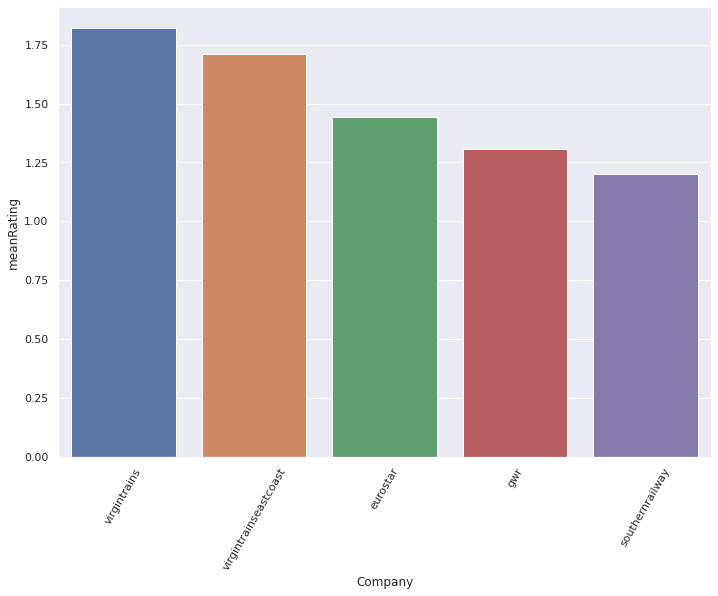

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="Company", y="meanRating", data=meanRatingPerCompany.sort_values(by='meanRating', ascending=False))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

This plots reveals that this tendency towards negative ratings is not caused by one or two 'bad' companies, but it relates to an overall performance of the top railway companies.
Having seen this there is no actual reason to isolate some of them and examine it as a unique situation

> Mean rating per year and per company

In [32]:
meanRatingPerYear = popularCompanies[['Company', 'Rating', 'Year']].groupby(['Year', 'Company']).mean() # form a suitable dataframe for the plot

In [33]:
meanRatingPerYear = meanRatingPerYear.reset_index()

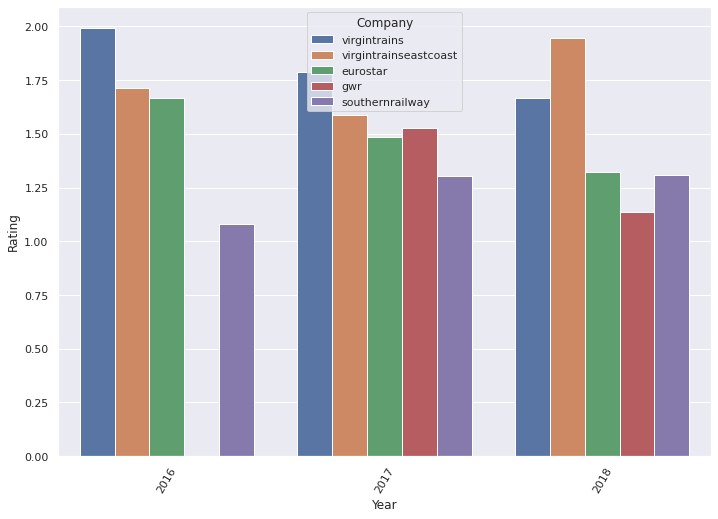

In [34]:
ax = sns.barplot(x="Year", y="Rating", data=meanRatingPerYear.sort_values(by='Rating', ascending=False), hue='Company')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

It is obvious that one of the top companies in terms of reviews (qwr) was not present in 2016. 
Furthermore, most of the companies (except for virgin trains east cost) are getting worse reviews every year passing. Southern Railway stayed at the same level

> Mean rating per travel timezone and company

In [35]:
meanRatingPerTimezone = popularCompanies[['Company', 'Rating', 'Train_timezone']].groupby(['Train_timezone', 'Company']).mean() # form a suitable dataframe for the plot

In [36]:
meanRatingPerTimezone = meanRatingPerTimezone.reset_index()

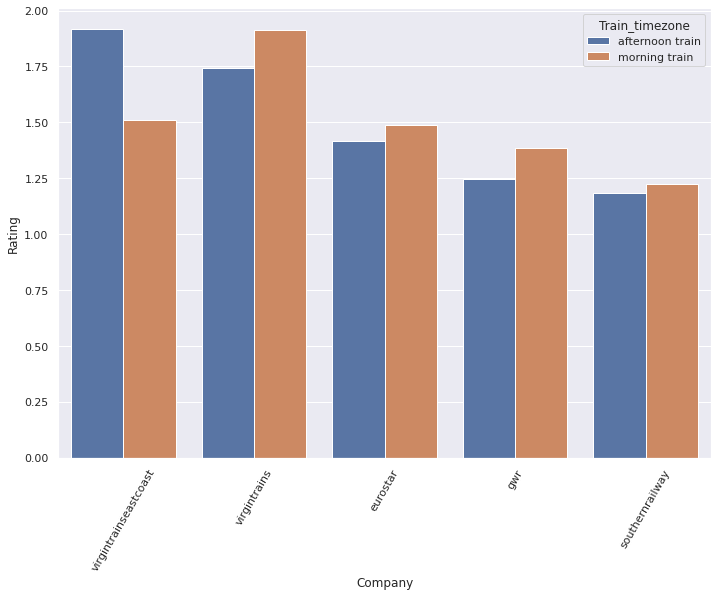

In [37]:
ax = sns.barplot(x="Company", y="Rating", data=meanRatingPerTimezone.sort_values(by='Rating', ascending=False), hue='Train_timezone')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

Most companies get better reviews on their morning train. On the other hand the differences are not so significant.

Considering "virgin train seasoncoast" the ratings are greater as regards the afternoon zone. And the difference is actually considerable.

> Mean rating per season and company

In [38]:
meanRatingPerSeason = popularCompanies[['Company', 'Rating', 'Season']].groupby(['Season', 'Company']).mean() # form a suitable dataframe for the plot

In [39]:
meanRatingPerSeason = meanRatingPerSeason.reset_index()

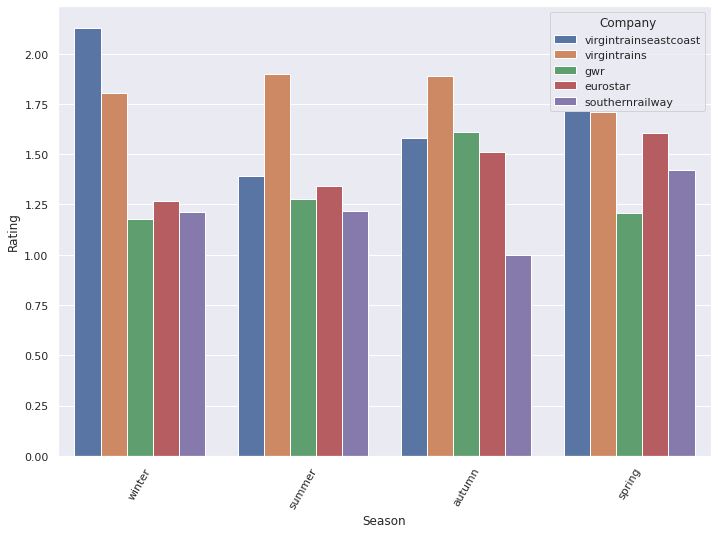

In [40]:
ax = sns.barplot(x="Season", y="Rating", data=meanRatingPerSeason.sort_values(by='Rating', ascending=False), hue='Company')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60);

 There is for sure diversity for ratings depending of the season for almost all top companies

Some highlights include the poor performance of "VirginTrainSeastCoast" in summer especially compared to their winter routes.
Virgin trains (orange) ratings are constant while the other companies exhibit less diversions.

# What are they talking about (negative reviews approach)

Α quick way to know what the people talks about is word frequency based plots. 

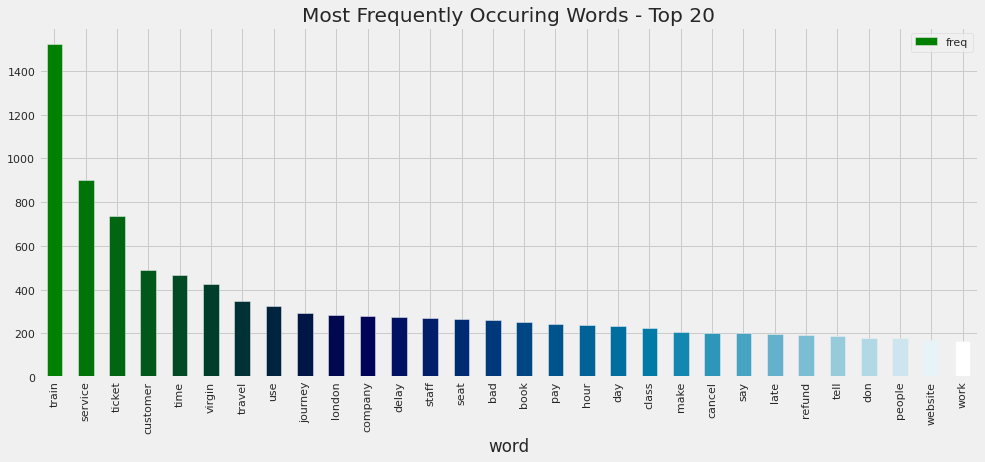

In [41]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df[df['Rating'].isin([1,2])]['Text_Cleaned'])  # I plot the results only for these comments that correspond to negative Ratings (1 or 2)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 30))
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

In [42]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'train' not in word
                                and 'travel' not in word
                            ])
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    #plt.title('travel topics of discussion', fontsize=25)

    #plt.savefig('topics.png', dpi=300, bbox_inches='tight')
    plt.show()

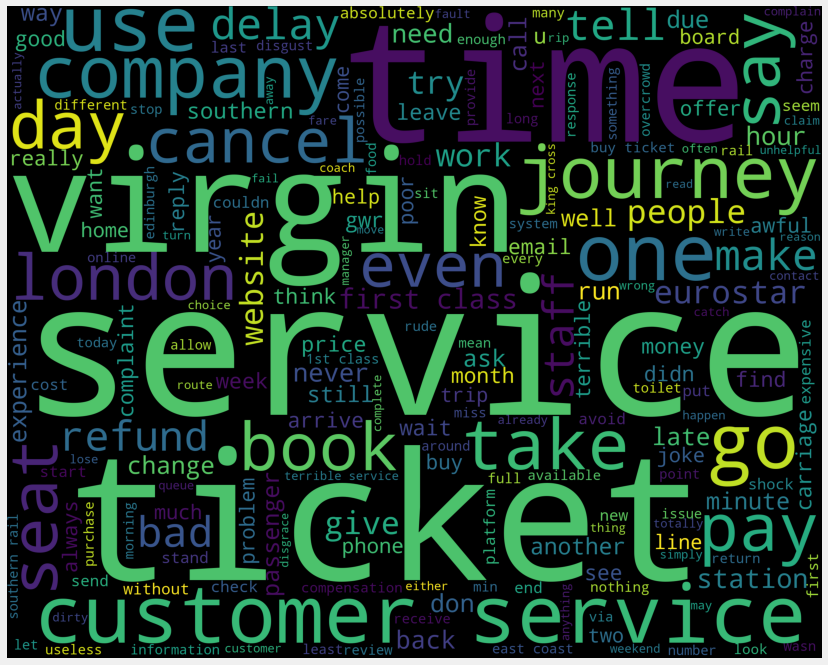

In [43]:
wc = wordcloud_draw(df[df['Rating'].isin([1,2])]['Text_Cleaned'],'black')

Of course some of the words are insignificant but the above plots are enough to conclude some general topics such as: Tickets policy, Virgin Company, delays, and payments.

The best way to think about this is to set a cluster-topic and attach the related words. For example the topic "Delayed trains" are consistent with words like delay, hours, minute, wait, late etc. 

The next step is to try and extract the different topics along with their top word occurancies. Thus it is time to exploit the Latent Dirichlet Allocation model:

# Topic Modelling based on all reviews

My aim here is to set some number of topics (like custers) and set a name that describes and summarizes their content

In [44]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
#tf = vectorizer.fit_transform(df[df['Rating'].isin([1,2])]['Text_Cleaned']).toarray()
tf = vectorizer.fit_transform(df['Text_Cleaned']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

# Choose the number of topics
number_of_topics = 3   # this is a little bit arbitrary. I made some tries and number 3 proved to be the most 'explainable' in terms of naming the topics
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [45]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [46]:
no_top_words = 30
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,service,651.4,train,1295.9,ticket,745.2
1,customer,307.4,get,351.4,not,325.3
2,first,271.1,time,290.7,get,294.5
3,class,270.3,service,240.0,book,276.7
4,train,257.9,not,236.1,train,251.2
5,virgin,249.5,seat,214.5,customer,226.7
6,not,234.5,late,200.8,eurostar,184.0
7,travel,192.8,london,181.7,virgin,179.8
8,use,146.0,cancel,166.3,website,177.2
9,delay,145.2,southern,157.3,time,166.4


> Lets now name the topics and give them meaning based on their top words

Topic 0: Most of these words suggest that the topic is about the experience of traveling after the boarding and up to the destination. The most significant words to keep and track are [seat, staff, journey, service, rude, experience, class, people, use, travel, first(class)]

Topic 1: This topic is mostly about the customer experience when trying to book a ticket, refund, or generally use their services before or after the route. The words we will track are [ticket, service, book, refund, website, call, buy, customer, change, phone, price, time]

Topic 2: This topic is about train delays. Words to keep are [service, delay, time, late, cancel, hour, take, refund, service]

So the next step is to run this model for 3 different years (2016-2018) and see how the specific weights for the corresponding words of each topics change with the year.
For that reason I will use the following helping functions to filter the produced datasets for each year

In [47]:
# There are helping function that will help me later to keep in my dataframe the meaningfull words and compare them year by year

def keepOnlyKeywords_TravelIssues(dataframe):
    dataframe = dataframe[dataframe['During Travel Issues'].isin(['seat', 'staff', 'service', 'journey',  'rude', 'experience', 'class', 'people', 'use', 'travel', 'first'])]
    return dataframe            
                         
def keepOnlyKeywords_Delays(dataframe):
    dataframe = dataframe[dataframe['Delays'].isin(['service', 'delay', 'time', 'late', 'cancel', 'hour', 'take', 'refund', 'service'])]
    return dataframe 

def keepOnlyKeywords_Tickets(dataframe):
    dataframe = dataframe[dataframe['Ticket Services'].isin(['ticket', 'service', 'book', 'refund', 'website', 'call', 'buy', 'customer', 'change', 'phone', 'price', 'time', 'change'])]
    return dataframe 

# What the customers are talking about throughout the years?

 > <b>2016 case </b>

In [48]:
df_2016 = df[df['Year']==2016]['Text_Cleaned']
tf = vectorizer.fit_transform(df_2016).toarray()

tf_feature_names = vectorizer.get_feature_names()

# Choose the number of topics
number_of_topics = 3
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)
display_topics(model, tf_feature_names, no_top_words).head()

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,train,137.3,train,219.3,first,66.3
1,service,113.1,get,125.9,class,62.3
2,not,102.1,service,99.0,seat,61.2
3,virgin,76.0,time,74.8,book,55.8
4,staff,75.7,delay,73.1,ticket,47.3


**** It should be clear that we cannot assume that the algorithm will produce the topics extracted before, with the same order.  ****

It is up to the user to produce the topic dataframe and then after taking a close look at the outputs he can assign the right topics to the corresponding columnn

2016:

topic 0 -> During Travel Issues

topic 1 -> Delays

topic 2 -> Ticket Services


In [49]:
topics_2016 = display_topics(model, tf_feature_names, no_top_words)

In [50]:
topics_2016.columns = ['During Travel Issues', 'During Travel Issues Weights', 
                       'Delays', 'Delays Weights', 
                       'Ticket Services', 'Ticket Services Weights']
topics_2016['Year'] = 2016


 > <b>2017 case </b>

In [51]:
df_2017 = df[df['Year']==2017]['Text_Cleaned']
tf = vectorizer.fit_transform(df_2017).toarray()

tf_feature_names = vectorizer.get_feature_names()

# Choose the number of topics
number_of_topics = 3
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)
display_topics(model, tf_feature_names, no_top_words).head()

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,service,353.2,ticket,275.6,get,125.2
1,train,337.0,train,183.6,train,121.3
2,customer,205.9,virgin,163.1,not,92.4
3,not,112.9,not,120.7,hour,88.5
4,bad,83.2,book,112.5,time,77.8


2017:

topic 0 -> Delays

topic 1 -> Ticket Services

topic 2 -> During Travel Issues


In [52]:
topics_2017 = display_topics(model, tf_feature_names, no_top_words)

In [53]:
topics_2017.columns = ['Delays', 'Delays Weights', 
                       'Ticket Services', 'Ticket Services Weights',
                       'During Travel Issues', 'During Travel Issues Weights']
                       
topics_2017['Year'] = 2017

 > <b>2018 case </b>

In [54]:
df_2018 = df[df['Year']==2018]['Text_Cleaned']
tf = vectorizer.fit_transform(df_2018).toarray()

tf_feature_names = vectorizer.get_feature_names()

# Choose the number of topics
number_of_topics = 3
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)
display_topics(model, tf_feature_names, no_top_words).head()

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights
0,train,453.3,train,219.5,service,238.6
1,get,160.9,virgin,114.4,ticket,177.9
2,seat,107.2,use,111.1,customer,165.6
3,not,105.4,staff,93.5,not,93.4
4,service,90.3,day,92.6,eurostar,71.1


2018:

topic 0 -> Delays

topic 1 -> During Travel Issues

topic 2 -> Ticket Services


In [55]:
topics_2018 = display_topics(model, tf_feature_names, no_top_words)

In [56]:
topics_2018.columns = ['Delays', 'Delays Weights', 
                       'During Travel Issues', 'During Travel Issues Weights',
                       'Ticket Services', 'Ticket Services Weights',
                       ]
                       
topics_2018['Year'] = 2018

Lets now concatenate all topics per year to a single final dataframe

In [57]:
# Concate
final = topics_2016.append([topics_2017, topics_2018])

# Convert types for later plotting use
final['Year'] = final['Year'].astype(str)
final['Delays Weights'] = final['Delays Weights'].astype(float)
final['Ticket Services Weights'] = final['Ticket Services Weights'].astype(float)
final['During Travel Issues Weights'] = final['During Travel Issues Weights'].astype(float)

# Delays discussion evolution throughout the years

Here I split it again per topic this time to get topic-personalized graphs

> Delays

In [58]:
delays_dataframe = final[['Delays', 'Delays Weights', 'Year']]
delays_dataframe = keepOnlyKeywords_Delays(delays_dataframe)

In [59]:
delays_plot = delays_dataframe[['Delays Weights', 'Year']].groupby(['Year']).sum()

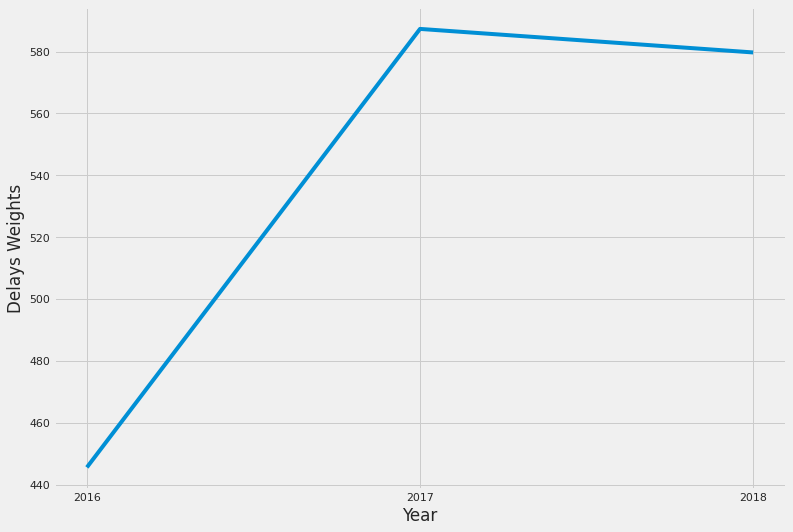

In [60]:
sns.lineplot(x='Year', y='Delays Weights', data=delays_plot.reset_index());

Here we can see that the discussion about delays illustrates an increase from 2016 to 2017 and then almost forms a plateau. 
In simple words people think that train routes are getting more and more delayed and thus they tend to talk about it more intense throughout the examined period of time

# "During Travel issues" discussion throughout the years

> During Travel issues

In [61]:
DuringTravel_dataframe = final[['During Travel Issues', 'During Travel Issues Weights', 'Year']]
DuringTravel_dataframe = keepOnlyKeywords_TravelIssues(DuringTravel_dataframe)

In [62]:
DuringTravel_plot = DuringTravel_dataframe[['During Travel Issues Weights', 'Year']].groupby(['Year']).sum()

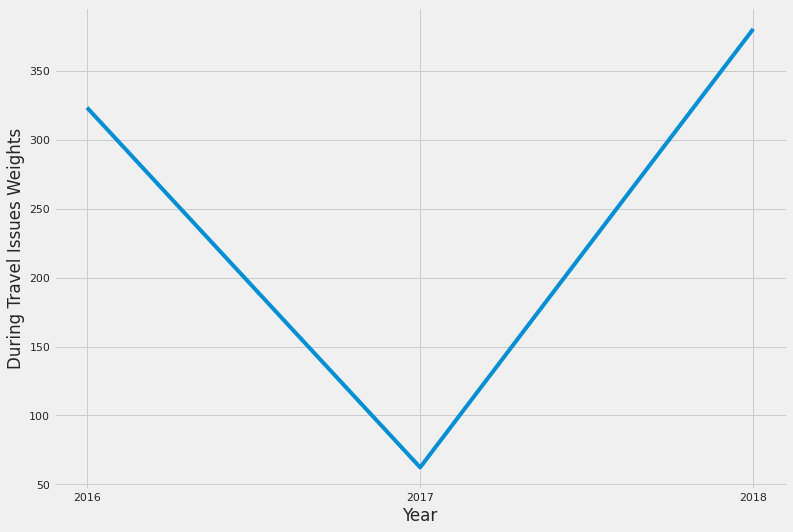

In [63]:
sns.lineplot(x='Year', y='During Travel Issues Weights', data=DuringTravel_plot.reset_index());

"During Travel Issues" topic found to be underdiscussed in 2017 exhibiting a dip from 2016 but then it exploded aigan to the highest level of these 3 years

# Tickets Services discussion throughout the years

> Ticket services

In [64]:
Tickets_dataframe = final[['Ticket Services', 'Ticket Services Weights', 'Year']]
Tickets_dataframe = keepOnlyKeywords_Tickets(Tickets_dataframe)

In [65]:
Tickets_plot = Tickets_dataframe[['Ticket Services Weights', 'Year']].groupby(['Year']).sum()

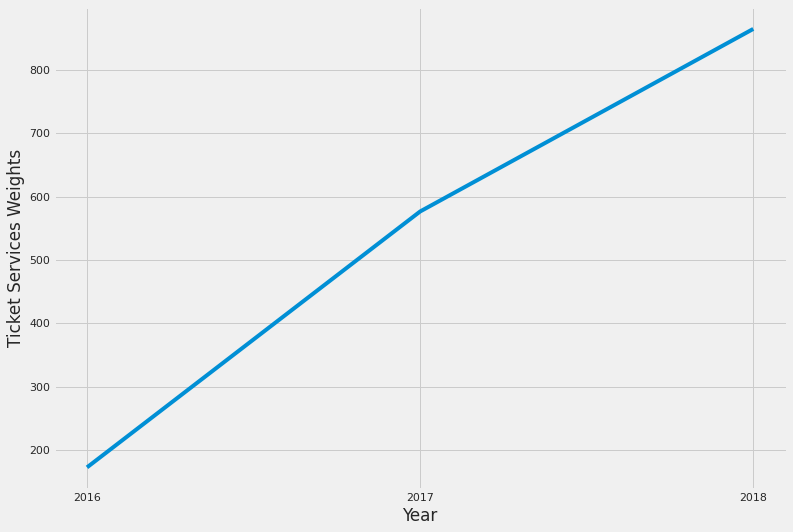

In [66]:
sns.lineplot(x='Year', y='Ticket Services Weights', data=Tickets_plot.reset_index());

 Here there is a clear constant increase on comments about tickets services. 

____________________________________________________

<h2> Some final thoughts and conclusions

The plan was to give EDA the chance to reveal some patterns that will lead me to a target and deploy a model around this target. 
My EDA plots do not reveal something extraordinary or hidden to focus on. Respecting the fact that I should spend around 5-8 hours on this, 
I approached all my data with an LDA model to extract some topics and then go by the year per topic to address the assignements questions.

Overall I want to emphasize on the final graphs "Topic per year evolution"

Specifically, the no1 problem is the 'Ticket Issues'. The intensity of the discussions towards this topic is found to be growing these 3 years. Ticket issues as seen in my analysis
may include both prices(keywords: price,pay,expensive) and booking/reservations(keywords: website, call, refund), so I would start advising our customer towards this direction. 

The delays discussion experienced a major increase from 2016 to 2017 but then started decreasing (slowly). Of course is a subject that should be taken into considaration but for the time is 
not as 'hot' as the tickets issue

Finally the 'During Travel Issues' which relates to problems/services/experience while traveling with the train exhibits a 'hard to evaluate' evolution.
It was found to be underdiscussed in 2017 exhibiting a dip from 2016 but then it exploded aigan to the highest level of these 3 years. For the time I would not advise anything to
the customer because this evolution may be cause due to lack of data, or maybe a statistical error or even a possible better tuning of the model. 


Beneath this cell I will discuss some 'future work' that could possibly give new dimensions to the solution of the problem and should be my next steps if I had to address this issue more excessively.

____________________________________________________

<h2> Topics Validation # 1

In [67]:
from sklearn.decomposition import NMF

In [ ]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
#tf = vectorizer.fit_transform(df[df['Rating'].isin([1,2])]['Text_Cleaned']).toarray()
tf = vectorizer.fit_transform(df['Text_Cleaned']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

# Choose the number of topics
number_of_topics = 3   # this is a little bit arbitrary. I made some tries and number 3 proved to be the most 'explainable' in terms of naming the topics
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

In [74]:
nmf = NMF(
    n_components=3, # default: 10
    beta_loss="kullback-leibler",
    solver='mu',
    # alpha_W=0.1,
    # alpha_H=0.1,
    # l1_ratio=0.5,
    random_state=0,
)

In [75]:
nmf.fit(tf)

NMF(alpha=0.0, beta_loss='kullback-leibler', init=None, l1_ratio=0.0,
    max_iter=200, n_components=3, random_state=0, shuffle=False, solver='mu',
    tol=0.0001, verbose=0)

In [82]:
def plot_top_words(model, feature_names, n_top_words=30):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Most frequent words per topic', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

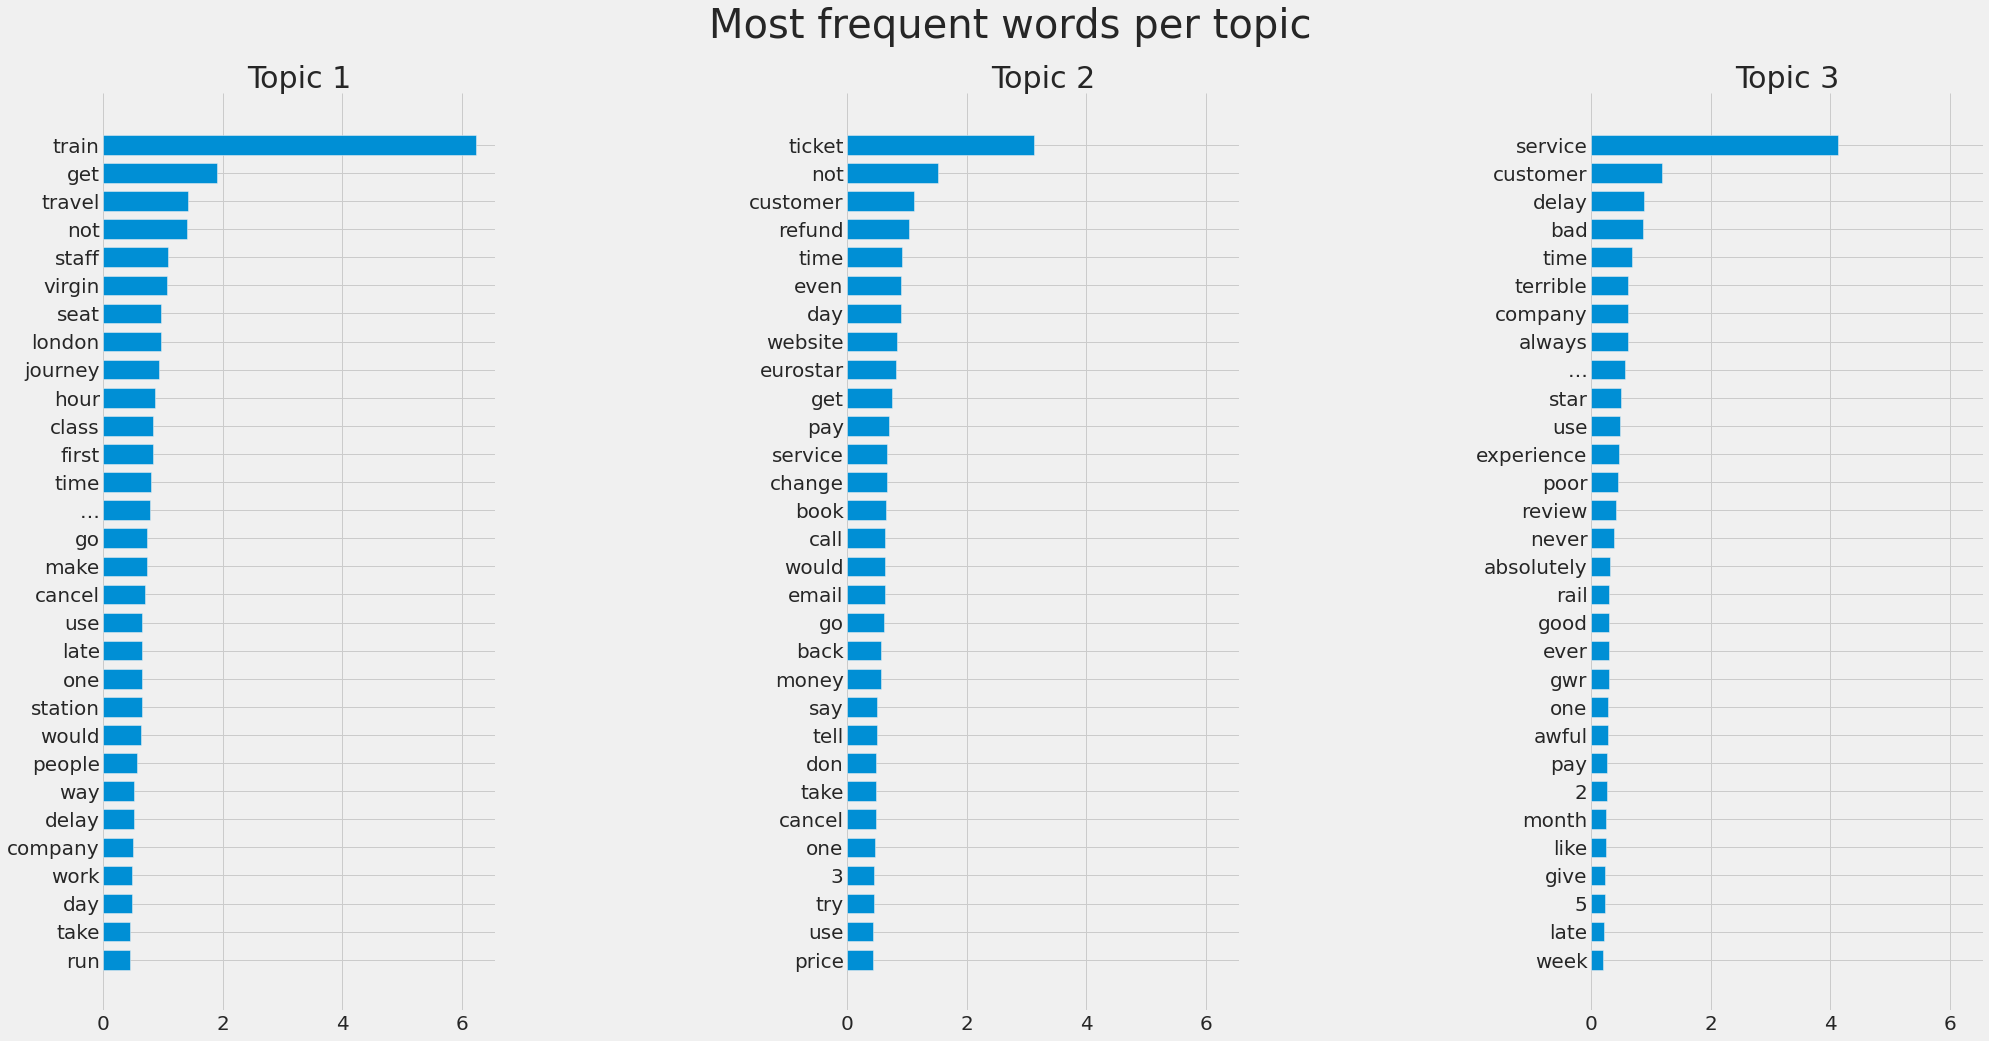

In [83]:
feature_names = vectorizer.get_feature_names()
plot_top_words(nmf, feature_names);

<h2> Seems that we can derive the same topics with a non-netagtive factorization matrix technique

Specifically:

Topic 1: During travel issues

Topic 2: Tickets sevices

Topic 3: Delay

<h2> Topics Validation #2

<h7> My goal here is to implement a k-means clustering to the cleaned text, pick k=3 clusters and then develop a wordcloud on each cluster to produce the main keywords. I want to see if I can derive the same topic names with this clustering technique as before

In [66]:
def vectorize(text, maxx_features):
    vectorizer = TfidfVectorizer(max_features=maxx_features, analyzer='word',stop_words= 'english')
    #vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [67]:
text = df['Text_Cleaned'].values
X = vectorize(text, 20)
X.shape

(1441, 20)

In [68]:
#PCA for dimension reduction and noise/outlier removal
#Produce the X_reduced to be used by t-SNE and K-means only

pca = PCA(n_components=0.9, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(1441, 17)

In [69]:
k =  3  # number of cluster
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['Cluster'] = y_pred

<ipython-input-69-54fcc3f0f068>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = y_pred


In [70]:
print('classes population:','\n',df['Cluster'].value_counts())

classes population: 
 2    675
0    407
1    359
Name: Cluster, dtype: int64


In [71]:
tsne = TSNE(verbose=1, perplexity=15, early_exaggeration = 14, random_state=42)
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1441 samples in 0.004s...
[t-SNE] Computed neighbors for 1441 samples in 0.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1441
[t-SNE] Computed conditional probabilities for sample 1441 / 1441
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.922981
[t-SNE] KL divergence after 1000 iterations: 1.245526


In [72]:
df['Cluster'].unique()

array([2, 1, 0], dtype=int32)

In [73]:
cluster0 = df[df['Cluster']==0]
cluster1 = df[df['Cluster']==1]
cluster2 = df[df['Cluster']==2]

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'train' not in word
                            and 'travel' not in word
                            and 'virgin' not in word
                            ])
    wordcloud = WordCloud(
                      background_color=color,
                      width=2500,
                      height=2000,
                     max_words = 50 
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    #plt.title('travel topics of discussion', fontsize=25)

    #plt.savefig('topics.png', dpi=300, bbox_inches='tight')
    plt.show()

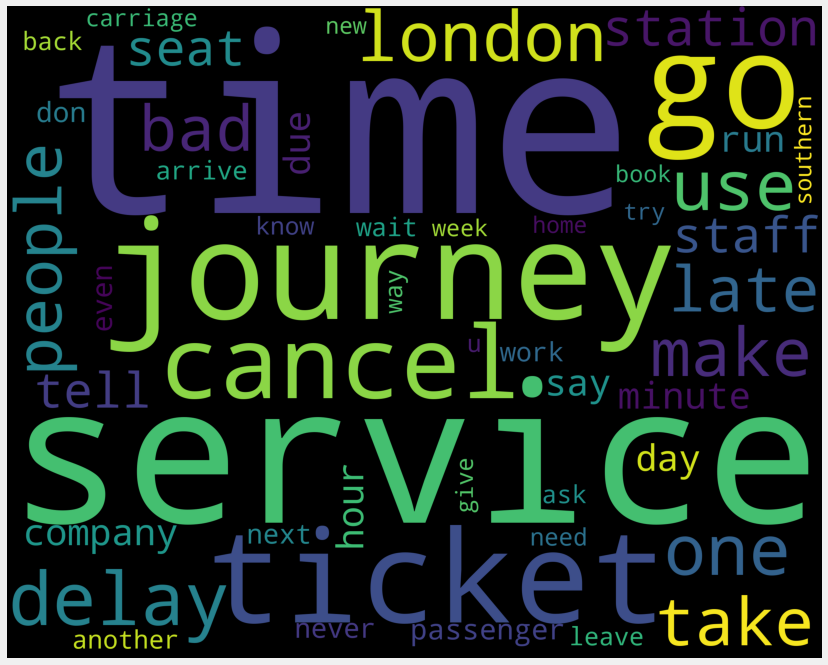

In [74]:
wc = wordcloud_draw(cluster0[cluster0['Rating'].isin([1,2])]['Text_Cleaned'], 'black',)

> <h4> This should be the "DELAY TOPIC" as words like time,delay,late,minute,hour,wait,arrive are present

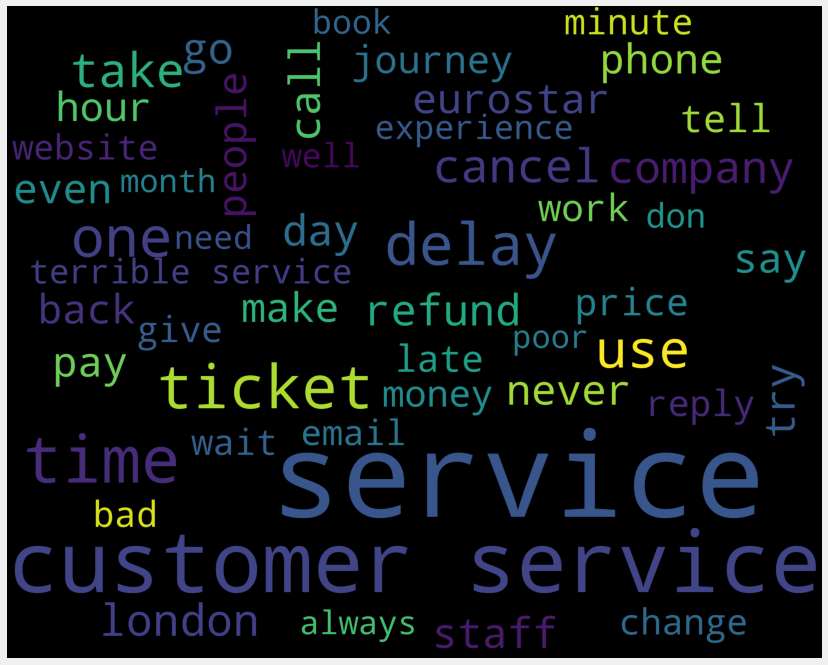

In [75]:
wc = wordcloud_draw(cluster1[cluster1['Rating'].isin([1,2])]['Text_Cleaned'],'black')

> <h4> This should be the "GENERAL ISSUES TOPIC" as words customer,service, experience, staff are present

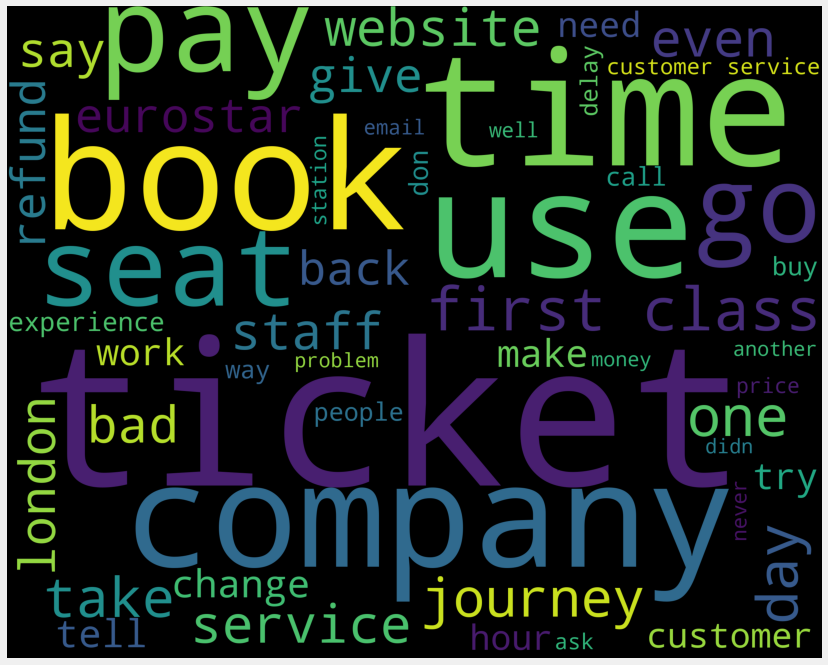

In [76]:
wc = wordcloud_draw(cluster2[cluster2['Rating'].isin([1,2])]['Text_Cleaned'],'black')

> <h4> This should be the "TICKET ISSUES" as words ticket,book,website,refund,change,pay are present